In [1]:
import torch
from readData import readData
train_data, test_data = readData()

In [102]:
LATENT_DIM = 100
BETA = 0.1
LR = 0.0001
BATCH_SIZE = 32

In [87]:
encoder = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, 5, padding=2),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 32, 5, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2,2),
    torch.nn.Flatten(),
    torch.nn.Linear(32*14*14, LATENT_DIM*2),
)
decoder = torch.nn.Sequential(
    torch.nn.Linear(LATENT_DIM, 32*14*14),
    torch.nn.ReLU(),
    torch.nn.Unflatten(1, (32, 14, 14)),
    torch.nn.ConvTranspose2d(32, 16, 2, stride=2),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(16, 1, 3, padding=1),
    torch.nn.Sigmoid()
)

In [103]:
from tqdm import tqdm
import random
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR)
mse_loss = torch.nn.MSELoss()
def runModel(encoder, decoder, data):
    input = torch.stack([torch.from_numpy(a[0]/255) for a in data]).float().unsqueeze(1)
    latent_distribution = encoder(input)
    latent_mean = latent_distribution[:, :LATENT_DIM]
    latent_logvar = latent_distribution[:, LATENT_DIM:]
    latent_std = torch.exp(latent_logvar/2)
    eps = torch.randn_like(latent_mean)
    latent = latent_mean + latent_std * eps
    output = decoder(latent)
    loss_recon = mse_loss(input,output)
    reg_term = torch.mean(torch.exp(latent_logvar)+latent_mean**2-1-latent_logvar)
    loss = loss_recon+BETA*reg_term
    return loss
def train(encoder, decoder, data):
    encoder.train()
    decoder.train()
    random.shuffle(data)
    for batch in tqdm(range(0,len(data)-BATCH_SIZE+1,BATCH_SIZE)):
        cur = data[batch:batch+BATCH_SIZE]
        loss = runModel(encoder, decoder, cur)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
def test(encoder, decoder, data):
    encoder.eval()
    decoder.eval()
    avg_loss = 0
    with torch.no_grad():
        for batch in tqdm(range(0,len(data)-BATCH_SIZE+1,BATCH_SIZE)):
            cur = data[batch:batch+BATCH_SIZE]
            loss = runModel(encoder, decoder, cur)
            avg_loss += loss
    return avg_loss/len(data)

In [104]:
for _ in range(3):
    train(encoder, decoder, train_data)
    print(test(encoder, decoder, test_data))

100%|██████████| 312/312 [00:02<00:00, 121.25it/s]


tensor(0.0017)


100%|██████████| 312/312 [00:02<00:00, 121.55it/s]


tensor(0.0017)


100%|██████████| 312/312 [00:02<00:00, 112.77it/s]

tensor(0.0016)


tensor([[ 0.0487,  0.3595, -0.0016, -1.0819,  0.2556, -0.0813, -0.8531, -1.0580,
          0.0994,  0.0374, -0.0524, -0.2590, -0.1732, -0.1819,  0.3305,  1.4057,
          0.1642, -0.3396,  0.2315,  0.8461, -0.0990, -0.4799, -0.0840, -0.4504,
          0.0331,  0.1048, -0.0770,  0.3701, -0.2125,  0.1106, -0.6271,  0.1152,
          0.0878,  0.0903, -0.0916, -0.0478,  0.1745, -0.0304,  0.1291,  0.2593,
          0.4688, -0.2845,  0.0850,  0.0941,  0.0628,  0.0692,  0.0164, -0.2600,
          0.0017, -0.1617, -0.1405, -0.0942, -0.1091, -0.3526, -0.1434, -0.1760,
          0.0940,  0.2665,  0.4112,  0.4374, -0.2872, -0.3370,  0.3433,  0.6240,
         -0.2017,  0.0687, -0.3500,  0.1847, -0.1407,  0.0479,  0.2540,  0.0721,
          0.0716,  0.2006, -0.0722,  0.1087, -0.3043,  0.0850, -0.3172,  0.1311,
          0.1515, -0.0346, -0.0424, -0.0362, -0.2318,  0.5346, -0.8597, -0.2340,
         -0.0266,  0.1218, -0.0221, -0.1666, -0.0358,  0.0622, -0.5776, -0.3960,
         -0.0968, -0.0979,  

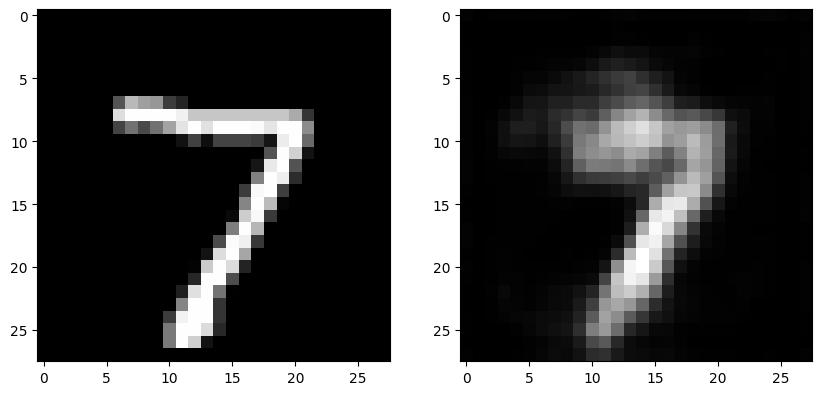

In [105]:
decoder.eval()
encoder.eval()
img = test_data[0][0]
img = torch.from_numpy(img/255).float().unsqueeze(0).unsqueeze(1)
latent_distribution = encoder(img)

latent_mean = latent_distribution[:, :LATENT_DIM]
latent_logvar = latent_distribution[:, LATENT_DIM:]
latent_std = torch.exp(latent_logvar/2)
eps = torch.randn_like(latent_mean)
latent = latent_mean + latent_std * eps
img2 = decoder(latent).squeeze(0).squeeze(0)
img2 = img2.detach().numpy()
img = img.squeeze(0).squeeze(0).detach().numpy()
print(latent_mean, latent_logvar)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')

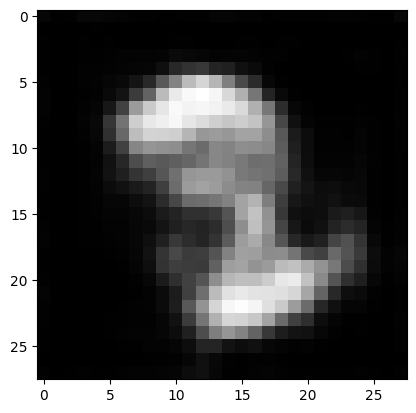

In [114]:
decoder.eval()
latent = torch.randn(1, LATENT_DIM)
img = decoder(latent).squeeze(0).squeeze(0)
img = img.detach().numpy()
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')

In [115]:
torch.save(encoder.state_dict(), "DigitCreation_encoder.pth")
torch.save(decoder.state_dict(), "DigitCreation_decoder.pth")